Цель работы:
- получить навыки сегментации изображений дорожного движения
с помощью модели нейронной сети U-Net

# Загрузка данных

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
from tqdm import tqdm
import numpy as np
from PIL import Image



def download_data(path_dataset, setname='Train'):
    dataset = []
    datalabel = []

    # Images
    img_path_dataset = path_dataset + '/Images/' + setname
    for filename in tqdm(sorted(os.listdir(path=img_path_dataset)), desc='Images'):
        img = Image.open(img_path_dataset + filename)
        img = np.array(img)
        dataset.append(np.array(img))

    # Masks
    mask_path_dataset = path_dataset + '/Masks/' + setname
    for filename in tqdm(sorted(os.listdir(path=mask_path_dataset)), desc='Masks'):
        mask = Image.open(mask_path_dataset + filename)
        mask = np.array(mask)
        datalabel.append(np.array(mask))

    return np.array(dataset), np.array(datalabel)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CustomSegmentationDataset(Dataset):
    def __init__(self, data, masks):
        self.data = data
        self.y = masks
        self.transform = transforms.Compose(
            [transforms.ToTensor() ]  # (H, W, C) - > (C, H, W)
        )
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = self.transform(image)
        target = self.y[idx]
        target = torch.tensor(target, dtype=torch.long)
        return image, target

In [25]:
main_dir = r"/content/drive/MyDrive/Colab Notebooks/materials/GTA5/Resized images"

print('TRAIN:')
X_train, y_train = download_data(main_dir, "Train/")
train_dataset = CustomSegmentationDataset(X_train, y_train)

print('\nVAL:')
X_test, y_test = download_data(main_dir, "Test/")
val_dataset = CustomSegmentationDataset(X_test, y_test)

TRAIN:


Masks: 100%|██████████| 301/301 [00:01<00:00, 193.64it/s]



VAL:


Masks: 100%|██████████| 201/201 [00:00<00:00, 215.18it/s]


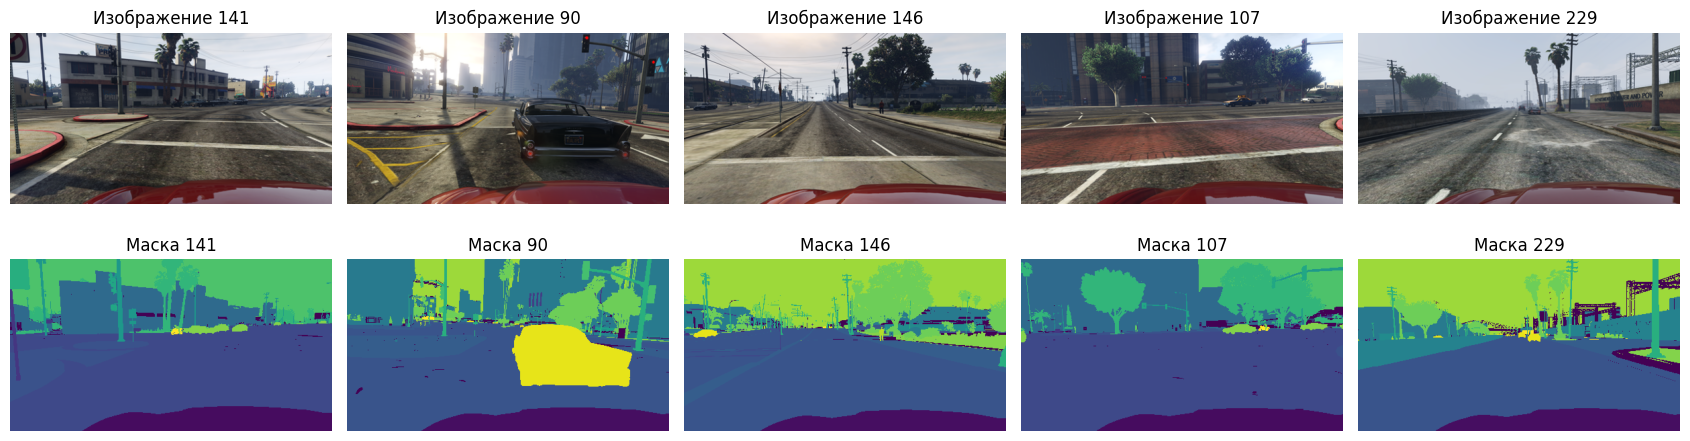

In [27]:
import random
import matplotlib.pyplot as plt

num_images = 5
random_indices = random.sample(range(len(X_train)), num_images)

plt.figure(figsize=(17, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(X_train[idx])
    plt.title(f"Изображение {idx}")
    plt.axis('off')
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(y_train[idx])
    plt.title(f"Маска {idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Реализация топологии нейронной сети U-Net

| Layer  | Type                         | Params                                                              | Output Shape       |
| ------ | ---------------------------- | ------------------------------------------------------------------- | ------------------ |
| conv1  | DoubleConv (2 Conv2d + ReLU) | 3→32 convs: (33332 + 32) + (323332 + 32) = 6,176 params             | [B, 32, H, W]      |
| pool1  | MaxPool2d(2)                 | 0                                                                   | [B, 32, H/2, W/2]  |
| conv2  | DoubleConv (2 Conv2d + ReLU) | 32→64 convs: (325564 + 64) + (645564 + 64) ≈ 205,824 params         | [B, 64, H/2, W/2]  |
| pool2  | MaxPool2d(2)                 | 0                                                                   | [B, 64, H/4, W/4]  |
| conv3  | DoubleConv (2 Conv2d + ReLU) | 64→128 convs: (6477128 + 128) + (12877128 + 128) ≈ 1,006,208 params | [B, 128, H/4, W/4] |
| up1    | Upsample (scale 2, bilinear) | 0                                                                   | [B, 128, H/2, W/2] |
| merge1 | Concatenation (c2 + up1)     | 0                                                                   | [B, 192, H/2, W/2] |
| conv4  | DoubleConv (2 Conv2d + ReLU) | 192→64 convs: (1925564 + 64) + (645564 + 64) ≈ 307,264 params       | [B, 64, H/2, W/2]  |
| up2    | Upsample (scale 2, bilinear) | 0                                                                   | [B, 64, H, W]      |
| merge2 | Concatenation (c1 + up2)     | 0                                                                   | [B, 96, H, W]      |
| conv5  | DoubleConv (2 Conv2d + ReLU) | 96→32 convs: (963332 + 32) + (323332 + 32) ≈ 55,808 params          | [B, 32, H, W]      |
| final  | Conv2d (32 → num_classes)    | 3233*num_classes + num_classes, for num_classes=35 → ~33,395 params | [B, 35, H, W]      |

In [12]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, num_classes=35):
        super(UNet, self).__init__()

        self.conv1 = self.double_conv2d(3, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = self.double_conv2d(32, 64, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = self.double_conv2d(64, 128, kernel_size=7)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv4 = self.double_conv2d(128+64, 64, kernel_size=5)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv5 = self.double_conv2d(64+32, 32, kernel_size=3)

        self.final = nn.Conv2d(32, num_classes, kernel_size=3, padding=1)


    def double_conv2d(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=kernel_size, padding=kernel_size//2
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=kernel_size, padding=kernel_size//2
            ),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        # Encoder
        c1_out = self.conv1(x)                              # [B, 32, H, W]
        p1_out = self.pool1(c1_out)                         # [B, 32, H/2, W/2]

        c2_out = self.conv2(p1_out)                         # [B, 64, H/2, W/2]
        p2_out = self.pool2(c2_out)                         # [B, 64, H/4, W/4]

        # Bottleneck
        c3_out = self.conv3(p2_out)                         # [B, 128, H/4, W/4]

        # Decoder
        up1_out = self.up1(c3_out)                          # [B, 128, H/2, W/2]
        merge1_out = torch.cat([c2_out, up1_out], dim=1)    # [B, 192, H/2, W/2]
        c4_out = self.conv4(merge1_out)                     # [B, 64, H/2, W/2]

        up2_out = self.up2(c4_out)                          # [B, 64, H, W]
        merge2_out = torch.cat([c1_out, up2_out], dim=1)    # [B, 96, H, W]
        c5_out = self.conv5(merge2_out)                     # [B, 32, H, W]

        # Output
        out = self.final(c5_out)                            # [B, num_classes, H, W]
        return out

In [13]:
# Model example
import torch

model = UNet()
x = torch.randn(32, 3, 100, 100)  # Batch of 32 images
output = model(x)
print(output.shape)
display(output[0])
del output

torch.Size([32, 35, 100, 100])


tensor([[[ 0.0236,  0.0232,  0.0251,  ...,  0.0191,  0.0217,  0.0202],
         [ 0.0064,  0.0085,  0.0068,  ...,  0.0205,  0.0131,  0.0219],
         [ 0.0175,  0.0150,  0.0137,  ...,  0.0212,  0.0243,  0.0260],
         ...,
         [ 0.0107,  0.0182,  0.0149,  ...,  0.0171,  0.0241,  0.0282],
         [ 0.0102,  0.0178,  0.0201,  ...,  0.0205,  0.0269,  0.0263],
         [ 0.0125,  0.0069,  0.0117,  ...,  0.0131,  0.0088,  0.0194]],

        [[ 0.0569,  0.0685,  0.0673,  ...,  0.0664,  0.0713,  0.0571],
         [ 0.0453,  0.0612,  0.0551,  ...,  0.0754,  0.0699,  0.0528],
         [ 0.0478,  0.0605,  0.0608,  ...,  0.0596,  0.0672,  0.0479],
         ...,
         [ 0.0521,  0.0637,  0.0618,  ...,  0.0612,  0.0639,  0.0463],
         [ 0.0530,  0.0600,  0.0565,  ...,  0.0601,  0.0635,  0.0456],
         [ 0.0421,  0.0472,  0.0482,  ...,  0.0549,  0.0458,  0.0359]],

        [[ 0.0102,  0.0074,  0.0028,  ...,  0.0089,  0.0090, -0.0033],
         [-0.0008,  0.0050, -0.0035,  ...,  0

## Обучение и тестирование нейронной сети

In [14]:
import torch

BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
NUM_CLASSES = 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cuda')

In [15]:
def train_val(train_loader, val_loader, model, criterion, optimizer):
    train_losses, val_losses = [], []

    for epoch in range(NUM_EPOCHS):
        # ~~~> 1. Learning epoch
        model.train()
        running_loss = 0.0

        train_loader_tqdm = tqdm(
            train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} - Training', unit='batch'
        )
        for batch_idx, (imgs, masks) in enumerate(train_loader_tqdm):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()

            if masks.ndim == 4: # [B, 1, H, W]
                masks = masks.squeeze(1) # [B, H, W]

            optimizer.zero_grad()
            outputs = model(imgs)
            # masks = masks.squeeze(1)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate online average loss
            current_batch = batch_idx + 1
            avg_loss = running_loss / current_batch

            train_loader_tqdm.set_postfix(
                loss=f'{avg_loss:.8f}'
            )

        # Avg train epoch loss
        train_loss = running_loss / len(train_loader)

        # ~~~> 2. Validation epoch
        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(DEVICE), masks.to(DEVICE).long()

                if masks.ndim == 4: # [B, 1, H, W]
                    masks = masks.squeeze(1) # [B, H, W]

                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item()

        # Avg val epoch loss
        val_loss = val_running_loss / len(val_loader)

        # ~~~> 3. Save epoch metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}]:"
            f"\n\t- train loss: {train_loss:.10f}"
            f"\n\t- val loss: {val_loss:.10f}"
        )

    return model, train_losses, val_losses

In [28]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [29]:
model = UNet(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [30]:
model, train_losses, val_losses = train_val(train_loader, val_loader, model, criterion, optimizer)

Epoch 1/10 - Training: 100%|██████████| 38/38 [00:22<00:00,  1.70batch/s, loss=3.04278833]


Epoch [1/10]:
	- train loss: 3.0427883299
	- val loss: 2.2756982996


Epoch 2/10 - Training: 100%|██████████| 38/38 [00:22<00:00,  1.69batch/s, loss=2.18233265]


Epoch [2/10]:
	- train loss: 2.1823326537
	- val loss: 2.1045720761


Epoch 3/10 - Training: 100%|██████████| 38/38 [00:22<00:00,  1.66batch/s, loss=1.97298058]


Epoch [3/10]:
	- train loss: 1.9729805777
	- val loss: 1.6620265933


Epoch 4/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.65batch/s, loss=1.67708951]


Epoch [4/10]:
	- train loss: 1.6770895123
	- val loss: 1.8619797138


Epoch 5/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.63batch/s, loss=1.56603450]


Epoch [5/10]:
	- train loss: 1.5660345021
	- val loss: 1.5194471799


Epoch 6/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.62batch/s, loss=1.48315727]


Epoch [6/10]:
	- train loss: 1.4831572740
	- val loss: 1.4926571204


Epoch 7/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.60batch/s, loss=1.44887262]


Epoch [7/10]:
	- train loss: 1.4488726227
	- val loss: 1.2677981051


Epoch 8/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.61batch/s, loss=1.38290871]


Epoch [8/10]:
	- train loss: 1.3829087082
	- val loss: 1.2629276583


Epoch 9/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.61batch/s, loss=1.39504068]


Epoch [9/10]:
	- train loss: 1.3950406752
	- val loss: 1.2113413054


Epoch 10/10 - Training: 100%|██████████| 38/38 [00:23<00:00,  1.61batch/s, loss=1.33366171]


Epoch [10/10]:
	- train loss: 1.3336617068
	- val loss: 1.1896453408


## Результат работы нейронной сети

In [31]:
import matplotlib.pyplot as plt
import random
import torch


def show_random_img_results(val_dataset, model):
    # Get random num_images
    num_images = 6
    random_indices = random.sample(range(len(val_dataset)), num_images)

    fig, axes = plt.subplots(3, num_images, figsize=(20, 7))
    model.eval()
    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            image, true_mask = val_dataset[idx] # image: [3, H, W], mask: [H,W]
            image_tensor = image.unsqueeze(0).to(DEVICE) # [1, 3, H, W]

            # Get predict
            output = model(image_tensor) # [1, 35, H, W]
            pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy() # [H, W]
            print("Уникальные значения:", np.unique(pred_mask))

            # Show input
            axes[0, i].imshow(image.permute(1, 2, 0).cpu().numpy())
            axes[0, i].set_title(f"Изображение {idx}")
            axes[0, i].axis('off')

            # Show label
            axes[1, i].imshow(true_mask.squeeze().cpu().numpy())
            axes[1, i].set_title(f"Маска {idx}")
            axes[1, i].axis('off')

            # Show pred
            axes[2, i].imshow(pred_mask)
            axes[2, i].set_title(f"Результат {idx}")
            axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

Уникальные значения: [ 1  7 11 21 23 26 27]
Уникальные значения: [ 1  7 11 21 22 23 26 27]
Уникальные значения: [ 1  7 11 21 22 23 26 27]
Уникальные значения: [ 1  7 11 21 22 23 26 27]
Уникальные значения: [ 1  7 11 21 22 23 26 27]
Уникальные значения: [ 1  7 11 21 22 23 26 27]


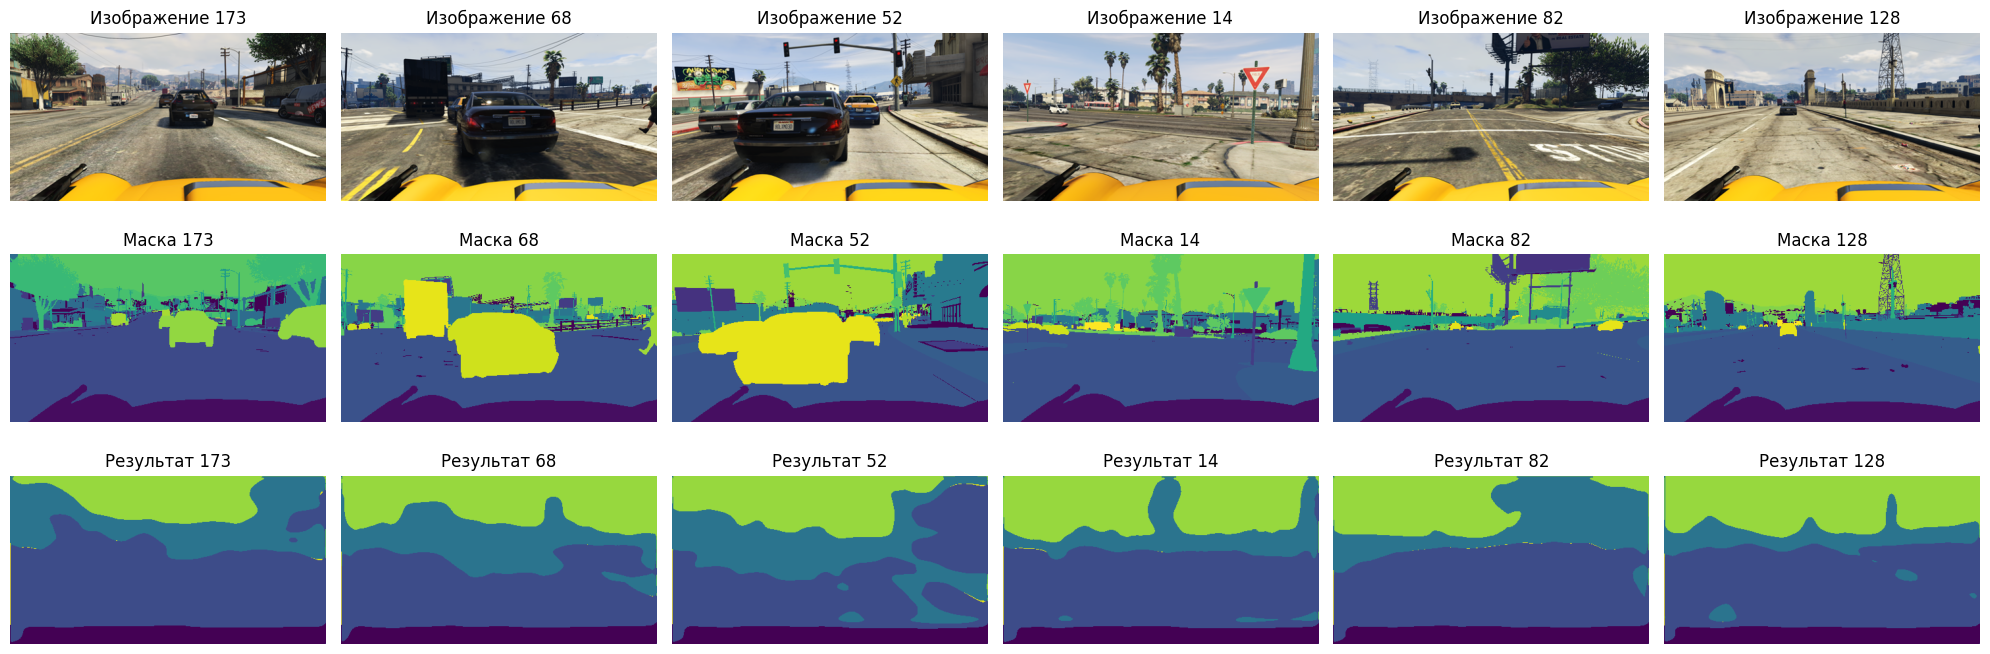

In [32]:
show_random_img_results(val_dataset, model)

# U-Net на базе VGG-16

VGG:
```
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU(inplace=True)
    (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (25): ReLU(inplace=True)
    (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)

    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)
```

VGGUNet:

| Layer      | Type                              | Params                                                 | Output Shape          |
| ---------- | --------------------------------- | ------------------------------------------------------ | --------------------- |
| Input      | [B, 3, H, W]                      | -                                                      | [B, 3, H, W]          |
| preprocess | Normalize                         | 0                                                      | [B, 3, H, W]          |
| conv2_1    | Sequential(2×Conv2d-64 + ReLUs)   | (3×3×3×64+64)×2 = 17,792                               | [B, 64, H, W]         |
| pool1      | MaxPool2d(2)                      | 0                                                      | [B, 64, H/2, W/2]     |
| conv2_2    | Sequential(2×Conv2d-128 + ReLUs)  | (64×3×3×128+128)×2 = 147,584                           | [B, 128, H/2, W/2]    |
| pool2      | MaxPool2d(2)                      | 0                                                      | [B, 128, H/4, W/4]    |
| conv3_3    | Sequential(3×Conv2d-256 + ReLUs)  | (128×3×3×256+256)×3 = 614,656                          | [B, 256, H/4, W/4]    |
| pool3      | MaxPool2d(2)                      | 0                                                      | [B, 256, H/8, W/8]    |
| conv3_4    | Sequential(3×Conv2d-512 + ReLUs)  | (256×3×3×512+512)×3 = 2,474,112                        | [B, 512, H/8, W/8]    |
| pool4      | MaxPool2d(2)                      | 0                                                      | [B, 512, H/16, W/16]  |
| conv2_5    | Bottleneck (512→1024×2 + Dropout) | (512×3×3×1024+1024) + (1024×3×3×1024+1024) = 9,455,232 | [B, 1024, H/16, W/16] |
| up4        | ConvTranspose2d(1024→1024)        | 1024×1024×2×2 = 4,194,304                              | [B, 1024, H/8, W/8]   |
| cat4       | Concat(u4+c4)                     | 0                                                      | [B, 1536, H/8, W/8]   |
| dec4       | DoubleConv(1536→512)              | (1536×3×3×512+512)×2 = 14,140,672                      | [B, 512, H/8, W/8]    |
| up3        | Upsample×2                        | 0                                                      | [B, 512, H/4, W/4]    |
| cat3       | Concat(u3+c3)                     | 0                                                      | [B, 768, H/4, W/4]    |
| dec3       | DoubleConv(768→256)               | (768×3×3×256+256)×2 = 3,541,888                        | [B, 256, H/4, W/4]    |
| up2        | ConvTranspose2d(256→256)          | 256×256×2×2 = 262,144                                  | [B, 256, H/2, W/2]    |
| cat2       | Concat(u2+c2)                     | 0                                                      | [B, 384, H/2, W/2]    |
| dec2       | DoubleConv(384→128)               | (384×3×3×128+128)×2 = 884,736                          | [B, 128, H/2, W/2]    |
| up1        | Upsample×2                        | 0                                                      | [B, 128, H, W]        |
| cat1       | Concat(u1+c1)                     | 0                                                      | [B, 192, H, W]        |
| dec1       | DoubleConv(192→64)                | (192×3×3×64+64)×2 = 221,248                            | [B, 64, H, W]         |
| up_final   | ConvTranspose2d(64→64)            | 64×64×2×2 = 16,384                                     | [B, 64, H+1, W+1]     |
| final      | DoubleConv(64→35, 1×1)            | (64×1×1×35+35)×2 = 9,075                               | [B, 35, H+1, W+1]     |
| output     | Interpolate(original_size)        | 0                                                      | [B, 35, H, W]         |

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16

class VGGUNet(nn.Module):
    def __init__(self, num_classes=35):
        super(VGGUNet, self).__init__()

        vgg = vgg16(pretrained=True)
        features = list(vgg.features.children())

        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

        # ENCODER
        # Let use first conv+ReLU (10) and poolings (4)
        self.conv2_1 = nn.Sequential(*features[:4]) # (Conv2d_1 + ReLU) + (Conv2d_2 + ReLU)
        self.pool1 = features[4]

        self.conv2_2 = nn.Sequential(*features[5:9]) # (Conv2d_3 + ReLU) + (Conv2d_4 + ReLU)
        self.pool2 = features[9]

        self.conv3_3 = nn.Sequential(*features[10:16]) # (Conv2d_5 + ReLU) + (Conv2d_6 + ReLU) + (Conv2d_7 + ReLU)
        self.pool3 = features[16]

        self.conv3_4 = nn.Sequential(*features[17:23]) # (Conv2d_8 + ReLU) + (Conv2d_9 + ReLU) + (Conv2d_10 + ReLU)
        self.pool4 = features[23]

        # Freeze all VGG layers and unfreeze conv2d_5 - conv2d_10
        for param in vgg.parameters():
            param.requires_grad = False
        for param in self.conv3_3.parameters():
            param.requires_grad = True
        for param in self.conv3_4.parameters():
            param.requires_grad = True


        # BOTTLENECK
        self.conv2_5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # DECODER
        self.up4 = nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2)
        self.dec4 = self.double_conv2d(1024 + 512, 512)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = self.double_conv2d(512 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec2 = self.double_conv2d(256 + 128, 128)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.double_conv2d(128 + 64, 64)

        self.up_final = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=1)
        self.final = self.double_conv2d(64, num_classes, kernel_size=1)

    def double_conv2d(self, in_channels, out_channels, kernel_size=3):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=kernel_size, padding=1
            ),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=out_channels, out_channels=out_channels,
                kernel_size=kernel_size, padding=1
            ),
            nn.ReLU(inplace=True)
        )

    def preprocess(self, x):
        if x.device != self.mean.device:
            self.mean = self.mean.to(x.device)
            self.std = self.std.to(x.device)
        x = (x - self.mean) / self.std
        return x

    def forward(self, x):
        torch.Size()

        original_size = x.shape[2:] # [H, W]
        x = self.preprocess(x)  # [B, 3, H, W]

        c1 = self.conv2_1(x)    # [B, 64, H, W]
        p1 = self.pool1(c1)     # [B, 64, H/2, W/2]

        c2 = self.conv2_2(p1)   # [B, 128, H/2, W/2]
        p2 = self.pool2(c2)     # [B, 128, H/2^2, W/2^2]

        c3 = self.conv3_3(p2)   # [B, 256, H/2^2, W/2^2]
        p3 = self.pool3(c3)     # [B, 256, H/2^3, W/2^3]

        c4 = self.conv3_4(p3)   # [B, 512, H/2^3, W/2^3]
        p4 = self.pool4(c4)     # [B, 512, H/2^4, W/2^4]

        b = self.conv2_5(p4)    # [B, 1024, H/2^4, W/2^4]

        u4 = self.up4(b)
        u4 = F.interpolate(
            u4, size=c4.shape[-2:], mode='bilinear'
        )                       # [B, 1024, H/2^3, W/2^3]
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.dec4(u4)      # [B, 512, H/2^3, W/2^3]

        u3 = self.up3(d4)
        u3 = F.interpolate(
            u3, size=c3.shape[-2:], mode='bilinear'
        )                       # [B, 512, H/2^2, W/2^2]
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.dec3(u3)      # [B, 256, H/2^2, W/2^2]

        u2 = self.up2(d3)
        u2 = F.interpolate(
            u2, size=c2.shape[-2:], mode='bilinear'
        )                       # [B, 256, H/2, W/2]
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.dec2(u2)      # [B, 128, H/2, W/2]

        u1 = self.up1(d2)       # [B, 128, H, W]
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.dec1(u1)      # [B, 64, H, W]

        out = self.up_final(d1)
        out = nn.functional.relu(out)
        # out = F.interpolate(
        #     out, size=original_size, mode='bilinear', align_corners=False
        # )
        out = self.final(out)
        out = F.interpolate(
            out, size=original_size, mode='bilinear', align_corners=False
        )

        return out


In [68]:
# Model example
import torch

model = VGGUNet()
x = torch.randn(32, 3, 100, 100)  # Batch of 32 images
output = model(x)
print(output.shape)
display(output[0])
del output

torch.Size([32, 35, 100, 100])


tensor([[[1.6132e-01, 1.6032e-01, 1.6032e-01,  ..., 1.6032e-01,
          1.6032e-01, 1.6132e-01],
         [1.6032e-01, 1.1047e-01, 1.0993e-01,  ..., 1.0976e-01,
          1.1047e-01, 1.6032e-01],
         [1.6032e-01, 1.0935e-01, 9.5061e-02,  ..., 9.6837e-02,
          1.0964e-01, 1.6032e-01],
         ...,
         [1.6032e-01, 1.0768e-01, 5.9674e-02,  ..., 6.8303e-02,
          1.0814e-01, 1.6032e-01],
         [1.6032e-01, 1.1034e-01, 1.0741e-01,  ..., 1.0800e-01,
          1.1037e-01, 1.6032e-01],
         [1.6132e-01, 1.6032e-01, 1.6032e-01,  ..., 1.6032e-01,
          1.6032e-01, 1.6132e-01]],

        [[6.8649e-02, 6.9221e-02, 6.9221e-02,  ..., 6.9221e-02,
          6.9221e-02, 6.8649e-02],
         [6.9221e-02, 9.7840e-02, 9.8243e-02,  ..., 9.8216e-02,
          9.7832e-02, 6.9221e-02],
         [6.9221e-02, 9.8222e-02, 1.0458e-01,  ..., 1.0646e-01,
          9.8247e-02, 6.9221e-02],
         ...,
         [6.9221e-02, 9.6090e-02, 6.6327e-02,  ..., 9.3098e-02,
          9.769

## Обучение и тестирование нейронной сети

In [34]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [35]:
vgg_model = VGGUNet(num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()

# Filter layers that should not be in gradient descent
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=LR
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 89.5MB/s]


In [36]:
vgg_model, train_losses, val_losses = train_val(train_loader, val_loader, vgg_model, criterion, optimizer)

Epoch 1/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.05batch/s, loss=3.27238968]


Epoch [1/10]:
	- train loss: 3.2723896754
	- val loss: 2.8908751744


Epoch 2/10 - Training: 100%|██████████| 38/38 [00:37<00:00,  1.02batch/s, loss=2.52938900]


Epoch [2/10]:
	- train loss: 2.5293889955
	- val loss: 1.9049767944


Epoch 3/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.04batch/s, loss=1.75096418]


Epoch [3/10]:
	- train loss: 1.7509641836
	- val loss: 1.7561085820


Epoch 4/10 - Training: 100%|██████████| 38/38 [00:37<00:00,  1.02batch/s, loss=1.65353612]


Epoch [4/10]:
	- train loss: 1.6535361158
	- val loss: 1.6619377686


Epoch 5/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.03batch/s, loss=1.51006309]


Epoch [5/10]:
	- train loss: 1.5100630930
	- val loss: 1.5799569350


Epoch 6/10 - Training: 100%|██████████| 38/38 [00:37<00:00,  1.03batch/s, loss=1.33625958]


Epoch [6/10]:
	- train loss: 1.3362595815
	- val loss: 1.1084409081


Epoch 7/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.03batch/s, loss=0.97097175]


Epoch [7/10]:
	- train loss: 0.9709717537
	- val loss: 1.0032034631


Epoch 8/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.03batch/s, loss=0.83680084]


Epoch [8/10]:
	- train loss: 0.8368008419
	- val loss: 0.9159829296


Epoch 9/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.03batch/s, loss=0.83321880]


Epoch [9/10]:
	- train loss: 0.8332187988
	- val loss: 0.8955902113


Epoch 10/10 - Training: 100%|██████████| 38/38 [00:36<00:00,  1.03batch/s, loss=0.76946961]


Epoch [10/10]:
	- train loss: 0.7694696078
	- val loss: 0.9407461996


## Результат работы нейронной сети

Уникальные значения: [ 1  5  7  8 11 15 17 20 21 23 26 27 28]
Уникальные значения: [ 1  7  8 11 15 17 20 21 23 26 27 28]
Уникальные значения: [ 1  5  7  8 11 15 17 20 21 22 23 26 27 28]
Уникальные значения: [ 1  7  8 11 15 17 20 21 23 26 27 28]
Уникальные значения: [ 1  5  7  8 11 13 15 17 20 21 23 26 27 28]
Уникальные значения: [ 1  5  7  8 11 13 15 17 20 21 22 23 26 27 28]


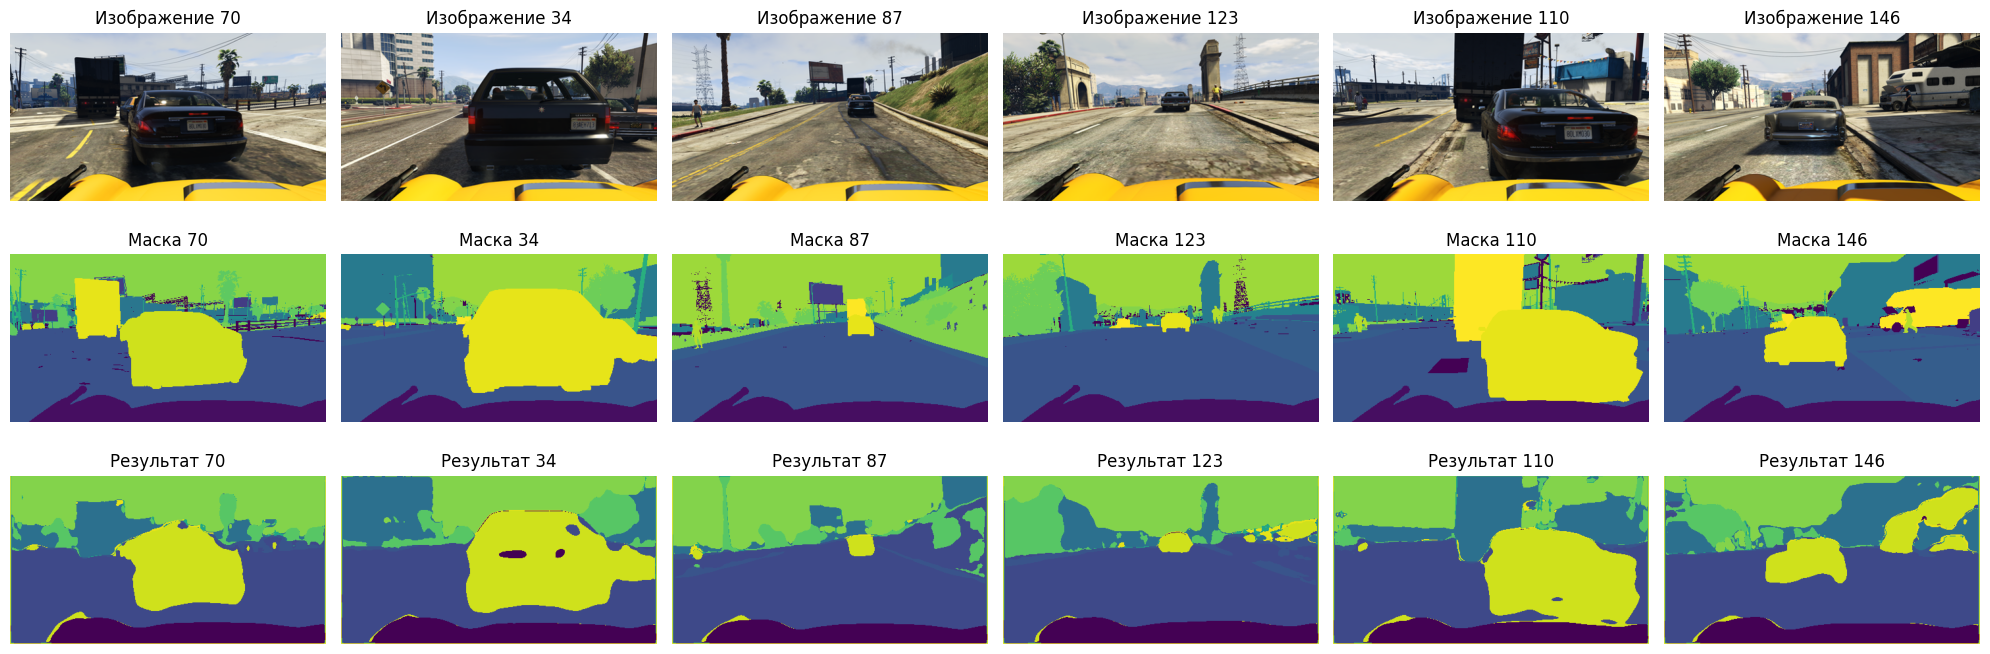

In [37]:
show_random_img_results(val_dataset, vgg_model)

# Выводы

Выводы довольно интересные. При старторвых данных:
```
BATCH_SIZE = 8
NUM_EPOCHS = 10
LR = 1e-4
NUM_CLASSES = 35
DEVICE = 'cuda'
```

Получились следующие результаты:

| | UNet | VGGUnet |
| --- | --- | --- |
| Среднее время отработки батча, сек | 22 | 36 |
| Финальные метрики | - train loss: 1.3336617068<br>- val loss: 1.1896453408 | - train loss: 0.7694696078<br>- val loss: 0.9407461996 |
| Маски наглядно | 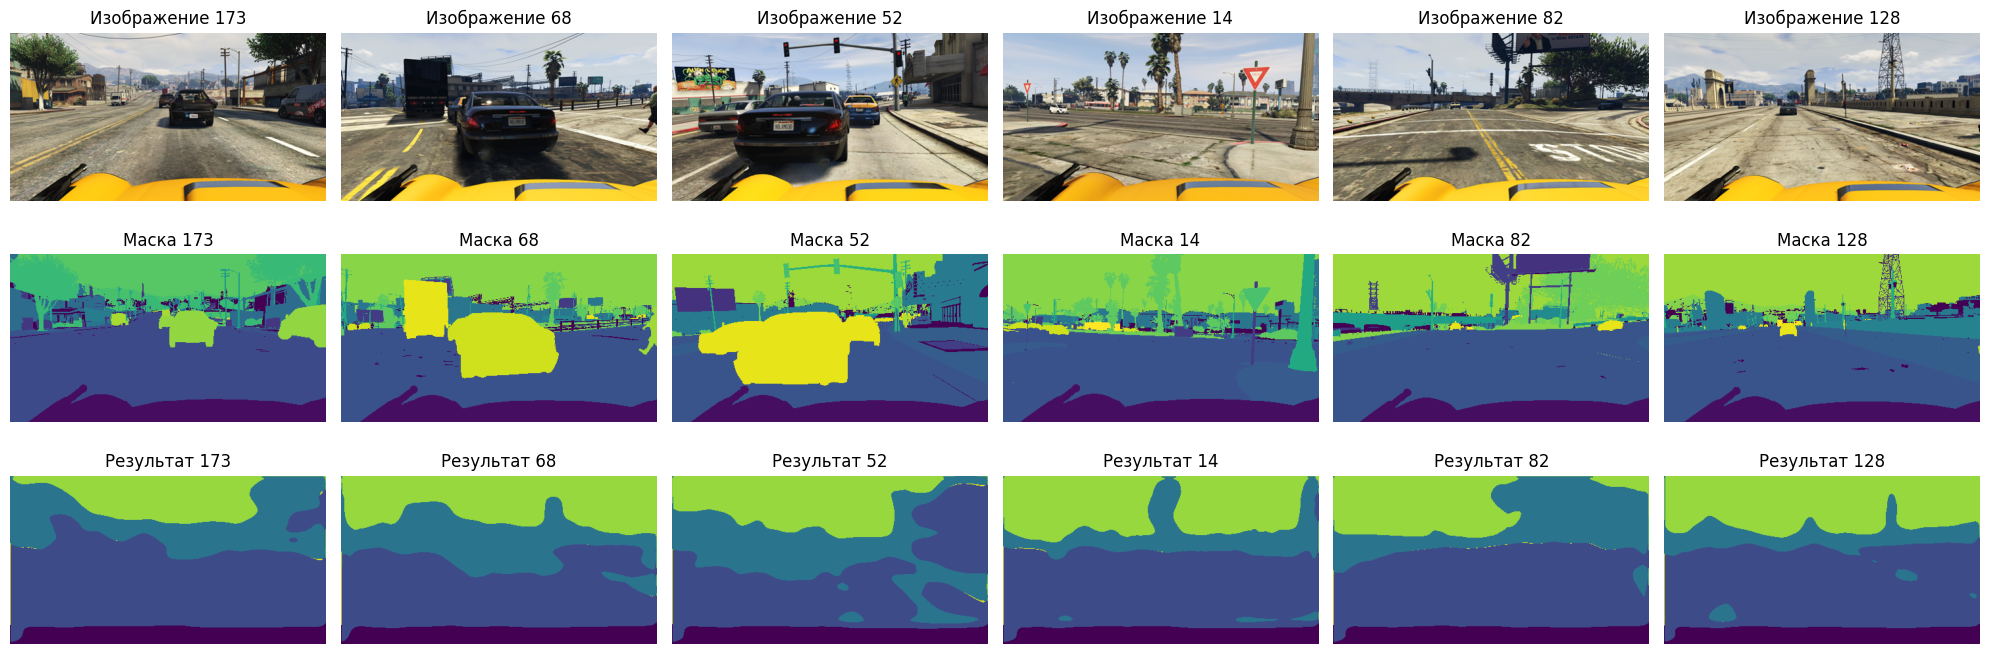 | 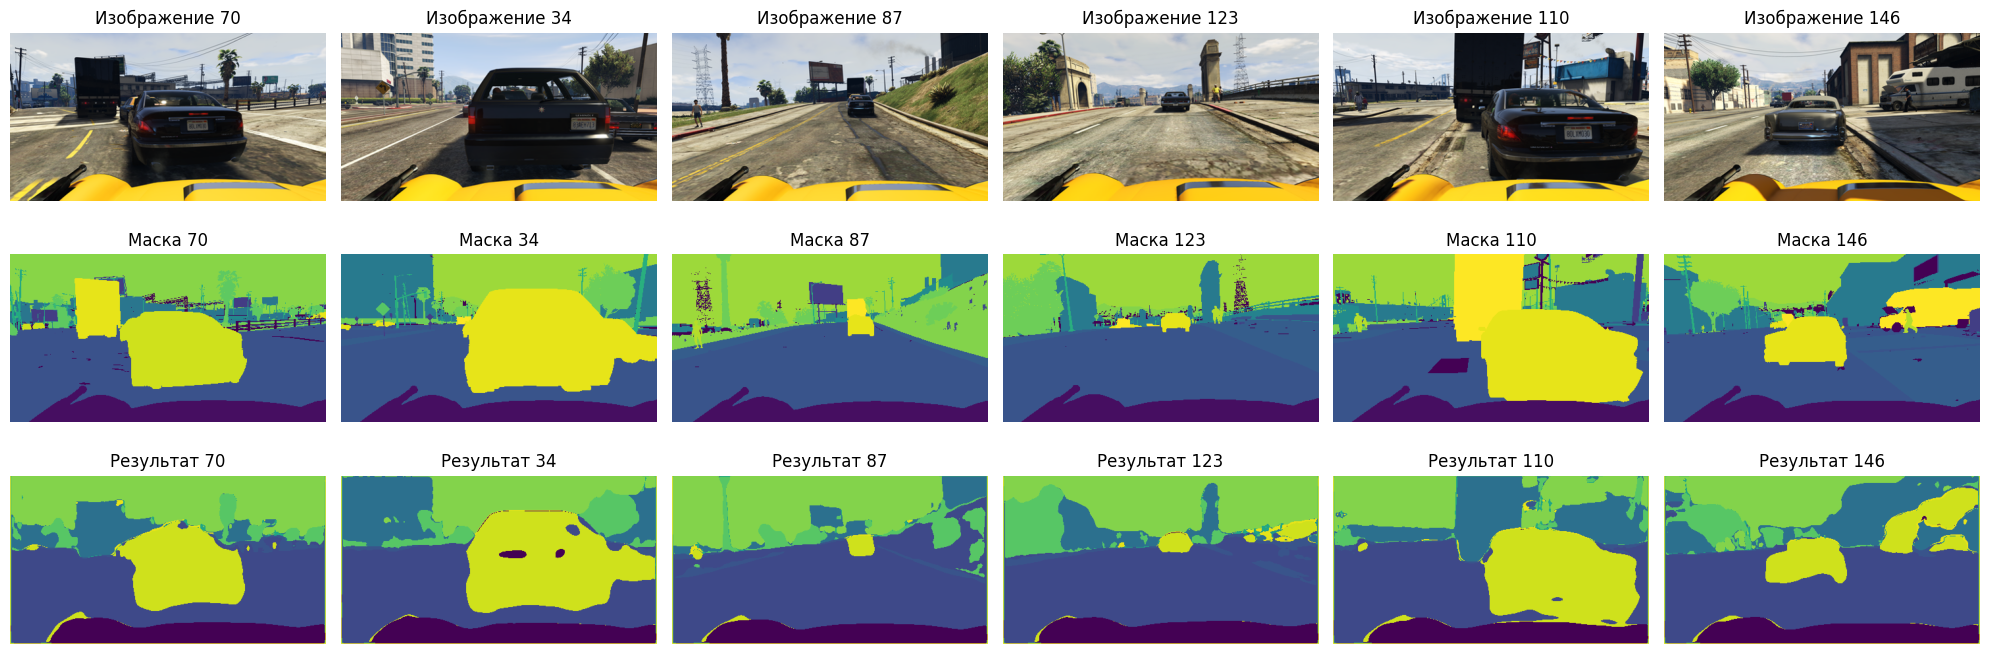 |






Основные выводы:
- Безусловно необходимо увеличивать колиечство эпох. Обе модели еще имеют огромный потенциал к обучению
- Обе модели показали свою обучающую способность
- VGGUnet затрачивает больше времени в рамках одного батча, однако учится значительно быстрее и эффективнее. В этом заслуга предобученного бэкбона. Уже спустя 10 батчей мы можем видеть очень хороший результат